In [4]:
import os, sys, argparse, importlib, time, inspect
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral
from sklearn.preprocessing import normalize
from spektral.data import DisjointLoader
from importlib import reload
import winsound
import dill, wandb, json,os
import datetime as dt
# if wandblog:
#     !wandb login b5b917a9390932e56fccfcbff6f528ccd85c44bf

Notebook
GPU detected


In [5]:
with open('compare/experiments/base.json') as file:
    construct_dict = json.load(file)

construct_dict['hyper_params']['hidden_states']=int(32)
construct_dict['data_params']['n_data']=int(2e4)   #just for tests, otherwise comment out  
construct_dict['data_params']['db_path']=construct_dict['data_params']['db_path'][3:]
construct_dict['data_params']['transform_path']=construct_dict['data_params']['transform_path'][3:]
construct_dict['group']='grad_tracker'

In [6]:
######
#dependencies
######

cwd=os.getcwd()
def get_lr_schedule(construct_dict):
    schedule  = construct_dict['run_params']['lr_schedule']
    lr_0        = construct_dict['run_params']['learning_rate']
    warm_up        = construct_dict['run_params']['warm_up']
    decay       = construct_dict['run_params']['lr_decay']

    import from_config.dev.lr_schedules as lr_module

    lr_generator = getattr(lr_module, schedule)

    lr_schedule  = lr_generator(lr_0, warm_up, decay)()

    return lr_schedule



def get_metrics(metric_name):
    # Returns a list of functions
    import from_config.dev.metrics as metrics
    metrics=getattr(metrics, metric_name)
    return metrics


def get_loss_func(name):
    # Return loss func from the loss functions file given a function name
    import from_config.dev.loss_funcs as loss_func_module
    loss_func = getattr(loss_func_module, name)
    return loss_func


def get_performance(name):
    # Return performance plotter from the eval_model file given a name
    import from_config.dev.eval_model as evals
    performance_plot = getattr(evals, name)
    return performance_plot 

def setup_model(construct_dict):
    # Retrieve name and params for construction
    model_name    = construct_dict['model_name']
    hyper_params  = construct_dict['hyper_params']
    experiment    = construct_dict['experiment']

    # Load model from model folder
    import from_config.dev.models as models
    model         = getattr(models, model_name) 
    model         = model(**hyper_params)

    # Make folder for saved states
    model_path    = osp.join(cwd, "trained_models", experiment)
    if not osp.isdir(model_path):
        os.makedirs(model_path)

    return model, model_path

In [55]:
def train_model(construct_dict):
    """
    Train a model given a construction dictionairy
    """

    # Setup Log 
    wandblog=construct_dict["wandblog"]
#     wandblog=0
    if wandblog:
        import wandb
        run = wandb.init(project = construct_dict["experiment"], entity = "chri862z", group=construct_dict["group"], config = construct_dict, reinit=True)
#         wandb.run.name = construct_dict['model_name']+'_'+construct_dict['experiment_name']+'_'+str(wandb.run.id)
        wandb.run.name = construct_dict['model_name']+'_'+str(wandb.run.id)
    ################################################
    #   Load dataset                              #
    ################################################
    from from_config.dev.data_load import graph_data
    #load dataset
    epochs      = construct_dict['run_params']['epochs']
    epochs=20
    batch_size  = construct_dict['run_params']['batch_size']
    
    dataset=graph_data(**construct_dict['data_params'])
    
    idx_lists = dataset.index_lists
    # Split data
    dataset_train = dataset[idx_lists[0]]
    dataset_val   = dataset[idx_lists[1]]
    dataset_test  = dataset[idx_lists[2]]

    loader_train = DisjointLoader(dataset_train, epochs=epochs, batch_size=batch_size)
    loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
    loader_val    = DisjointLoader(dataset_val, epochs = 1,      batch_size = batch_size)

     ###############################################
    #   Setup other run params                     #
    ################################################

    early_stop  = construct_dict['run_params']['early_stop']
    patience    = construct_dict['run_params']['patience']
    val_epoch = construct_dict['run_params']['val_epoch']

    print('check')
    ################################################
    #   Setup model, loss, lr schedule and metrics #
    ################################################

    # Get model, metrics, lr_schedule and loss function
    model, model_path     = setup_model(construct_dict)
    loss_func             = get_loss_func(construct_dict['run_params']['loss_func'])
    metrics               = get_metrics(construct_dict['run_params']['metrics'])
    performance_plot      = get_performance(construct_dict['run_params']['performance_plot'])
    lr_schedule          = get_lr_schedule(construct_dict)
    save_path=osp.join(model_path,wandb.run.name)

    if not osp.isdir(save_path):
        os.makedirs(save_path)
        print('New folder for saving run made')

    # Learning rate and optimizer
    learning_rate            = next(lr_schedule)
    opt           = Adam(learning_rate)

    ################################################
    #   Set up TF functions and validation step   #
    ################################################


    # Define training function
    @tf.function(input_signature = loader_train.tf_signature(), experimental_relax_shapes = True)
    def train_step(inputs, targets):
        with tf.GradientTape() as tape:
            predictions = model(inputs, training = True)
            targets     = tf.cast(targets, tf.float32)
            loss        = loss_func(predictions, targets)
            loss       += sum(model.losses)

        gradients = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    @tf.function(input_signature = loader_test.tf_signature(), experimental_relax_shapes = True)
    def test_step(inputs, targets):
        predictions = model(inputs, training = False)
        targets     = tf.cast(targets, tf.float32) 
        out         = loss_func(predictions, targets)

        return predictions, targets, out


    def validation(loader):
        loss = 0
        prediction_list, target_list = [], []
        for batch in loader:
            inputs, targets = batch
            predictions, targets, out = test_step(inputs, targets)
            loss           += out
            
            prediction_list.append(predictions)
            target_list.append(targets)
        
        y_reco  = tf.concat(prediction_list, axis = 0)
        y_true  = tf.concat(target_list, axis = 0)
        y_true  = tf.cast(y_true, tf.float32)

        loss, loss_from = loss_func(y_reco, y_true, re=True)
        
        energy, e_old, alpha, zeni, azi= metrics(y_reco, y_true)
        
        return loss, loss_from, [energy, e_old, alpha, zeni, azi]

    # Define grad tracking function
    @tf.function(experimental_relax_shapes = True)
    def gradient_importance(inputs, targets, j):
        with tf.GradientTape() as tape:
            tape.watch(inputs[0])
            predictions = model(inputs, training=False)[:,j] # needs to be under the gradient tape to be tracked

        grads = tape.gradient(predictions, inputs[0])
        grads=tf.where(tf.math.is_nan(grads), tf.zeros_like(grads), grads)

        grads=tf.math.segment_mean(tf.math.abs(grads), inputs[2], name=None)
        return grads

    ################################################
    #  Train Model                                 #      
    ################################################
    j=0
    tot_time=0
    current_batch = 0
    current_epoch = 1
    loss          = 0
    lowest_loss   = np.inf
    early_stop    = 1
    early_stop_counter    = 0
    pbar          = tqdm(total = loader_train.steps_per_epoch, position=0, leave = True)
    start_time    = time.time()
    summarylist=[]
    for batch in loader_train:
        inputs, targets = batch
        out             = train_step(inputs, targets)
        loss           += out
        if current_epoch==1 and current_batch==0:
            model.summary()
            if wandblog:
                summary=model.summary(print_fn=summarylist.append)
                table=wandb.Table(columns=["Layers"])
                for s in summarylist:
                    table.add_data(s)
                wandb.log({'Model summary': table})
        current_batch  += 1
        pbar.update(1)
        pbar.set_description(f"Epoch {current_epoch} / {epochs}; Avg_loss: {loss / current_batch:.6f}")
        
        if current_batch == loader_train.steps_per_epoch:
            t=time.time() - start_time
            tot_time+=t
            print(f"Epoch {current_epoch} of {epochs} done in {t:.2f} seconds using learning rate: {learning_rate:.2E}")
            print(f"Avg loss of train: {loss / loader_train.steps_per_epoch:.6f}")

            loader_val    = DisjointLoader(dataset_val, epochs = 1,      batch_size = batch_size)
            val_loss, val_loss_from, val_metric = validation(loader_val)
#             if wandblog:
#                 wandb.log({"Train Loss":      loss / loader_train.steps_per_epoch,
#                         "Validation Loss": val_loss, 
#                         "w(log(E))":   val_metric[1],
#                         "Energy bias":   val_metric[0][1],
#                         "Solid angle 68th":    val_metric[2][3],
#                         "Angle bias":   val_metric[2][1],
#                         "zenith 68th":    val_metric[3][3],
#                         "zenith bias":   val_metric[3][1],
#                         "azimuth 68th":    val_metric[4][3],
#                         "azimuth bias":   val_metric[4][1]})
            grad_dict={'energy':{'dom_x':1,
                      'dom_y':1,
                      'dom_z':1,
                      'time':1,
                      'logcharge':1,
                      'SRT':1},
                       'zenith':{'dom_x':1,
                      'dom_y':1,
                      'dom_z':1,
                      'time':1,
                      'logcharge':1,
                      'SRT':1},
                      'azimuth':{'dom_x':1,
                      'dom_y':1,
                      'dom_z':1,
                      'time':1,
                      'logcharge':1,
                      'SRT':1},
                      'sig_zeni':{'dom_x':1,
                      'dom_y':1,
                      'dom_z':1,
                      'time':1,
                      'logcharge':1,
                      'SRT':1},
                      'sig_azi':{'dom_x':1,
                      'dom_y':1,
                      'dom_z':1,
                      'time':1,
                      'logcharge':1,
                      'SRT':1}}
            keys=list(grad_dict.keys())
            feats=list(grad_dict[keys[0]].keys())
            for j in range(len(keys)):  
                grads=gradient_importance(inputs, targets, j)
                grads_av=tf.reduce_mean(grads, axis=0)
                grads_av=grads_av/tf.reduce_sum(grads_av) #softmax
                for i, feat in enumerate(feats):
                    grad_dict[keys[j]][feat]=grads_av[i]
            if wandblog:
                wandb.log(grad_dict)
                
            if not construct_dict['run_params']['zeniazi_metric']:
                print(f"Avg loss of validation: {val_loss:.6f}")
                print(f"Loss from:  Energy: {val_loss_from[0]:.6f} \t Angle: {val_loss_from[1]:.6f} ")
                print(f"Energy: bias = {val_metric[0][1]:.6f} sig_range = {val_metric[0][0]:.6f}<->{val_metric[0][2]:.6f}, old metric {val_metric[1]:.6f}\
                    \n Angle: bias = {val_metric[2][1]:.6f} sig_range = {val_metric[2][0]:.6f}<->{val_metric[2][2]:.6f}, old metric {val_metric[2][3]:.6f}")
            else:
                print(f"Avg loss of validation: {val_loss:.6f}")
                print(f"Loss from:  Energy: {val_loss_from[0]:.6f} \t Angle: {val_loss_from[1]:.6f} ")
                print(f"Energy: bias = {val_metric[0][1]:.6f} sig_range = {val_metric[0][0]:.6f}<->{val_metric[0][2]:.6f}, old metric {val_metric[1]:.6f}\
                    \n Angle: bias = {val_metric[2][1]:.6f} sig_range = {val_metric[2][0]:.6f}<->{val_metric[2][2]:.6f}, old metric {val_metric[2][3]:.6f}\
                    \n Zenith: bias = {val_metric[3][1]:.6f} sig_range = {val_metric[3][0]:.6f}<->{val_metric[3][2]:.6f}, old metric {val_metric[3][3]:.6f}\
                    \n Azimuth: bias = {val_metric[4][1]:.6f} sig_range = {val_metric[4][0]:.6f}<->{val_metric[4][2]:.6f}, old metric {val_metric[4][3]:.6f}")

            if val_loss < lowest_loss:
                early_stop_counter = 0
                lowest_loss        = val_loss
            else:
                early_stop_counter += 1
            print(f'Early stop counter: {early_stop_counter}/{patience}, lowest val loss was {lowest_loss:.6f}')
            if early_stop and (early_stop_counter >= patience):
                model.save(save_path)
                print(f"Stopped training. No improvement was seen in {patience} epochs")
#                 return current_epoch

            if current_epoch != epochs:
                pbar          = tqdm(total = loader_train.steps_per_epoch, position=0, leave = True)

            learning_rate = next(lr_schedule)
            opt.learning_rate.assign(learning_rate)

            time_avg=tot_time/current_epoch
            if current_epoch % val_epoch == 0:
                model.save(save_path)
                print("Model saved")
                if wandblog:
                    loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
                    fig, _ = performance_plot(loader_test, test_step, metrics, save=True, save_path=save_path)
                    title="performanceplot_"+str(current_epoch)
                    wandb.log({title: [wandb.Image(fig, caption=title)]})
        
            loss            = 0
            start_time      = time.time()
            current_epoch  += 1
            current_batch   = 0
    return grad_list, grad_mean
    

In [56]:
full, means=train_model(construct_dict)

_runtime,110
_timestamp,1618606715
_step,5


_runtime,▁▃▄▆▇█
_timestamp,▁▃▄▆▇█
_step,▁▂▄▅▇█


wandb: wandb version 0.10.26 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Loading data to memory
check
New folder for saving run made


Model: "sage_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
mp_13 (MP)                   multiple                  17056     
_________________________________________________________________
graph_sage_conv_26 (GraphSag multiple                  4096      
_________________________________________________________________
graph_sage_conv_27 (GraphSag multiple                  16384     
_________________________________________________________________
global_max_pool_13 (GlobalMa multiple                  0         
_________________________________________________________________
global_avg_pool_13 (GlobalAv multiple                  0         
_________________________________________________________________
global_sum_pool_13 (GlobalSu multiple                  0   

Exception ignored in: <function tqdm.__del__ at 0x00000274E9BC5820>
Traceback (most recent call last):
  File "C:\Users\chris\anaconda3\lib\site-packages\tqdm\std.py", line 1122, in __del__
    self.close()
  File "C:\Users\chris\anaconda3\lib\site-packages\tqdm\notebook.py", line 257, in close
    super(tqdm_notebook, self).close(*args, **kwargs)
  File "C:\Users\chris\anaconda3\lib\site-packages\tqdm\std.py", line 1323, in close
    fp_write('')
  File "C:\Users\chris\anaconda3\lib\site-packages\tqdm\std.py", line 1320, in fp_write
    self.fp.write(_unicode(s))
  File "C:\Users\chris\anaconda3\lib\site-packages\tqdm\utils.py", line 223, in inner
    return func(*args, **kwargs)
  File "C:\Users\chris\anaconda3\lib\site-packages\wandb\sdk\lib\redirect.py", line 100, in new_write
    cb(name, data)
  File "C:\Users\chris\anaconda3\lib\site-packages\wandb\sdk\wandb_run.py", line 796, in _console_callback
    self._backend.interface.publish_output(name, data)
  File "C:\Users\chris\anac

Avg loss of validation: 4.920830
Loss from:  Energy: 3.792914 	 Angle: 0.407287 
Energy: bias = 3.494504 sig_range = 2.727172<->4.659106, old metric 0.935895                    
 Angle: bias = 43.809258 sig_range = 20.445307<->73.027863, old metric 56.896965                    
 Zenith: bias = 15.381200 sig_range = 4.581998<->34.221886, old metric 22.989454                    
 Azimuth: bias = 84.588943 sig_range = 21.485302<->145.361374, old metric 115.909401
Early stop counter: 0/5, lowest val loss was 4.920830


Epoch 2 of 20 done in 16.44 seconds using learning rate: 2.50E-04
Avg loss of train: 4.791713

Avg loss of validation: 3.891491
Loss from:  Energy: 2.948750 	 Angle: 0.238265 
Energy: bias = 2.637566 sig_range = 1.708909<->3.950245, old metric 1.080831                    
 Angle: bias = 49.145771 sig_range = 24.385509<->80.076370, old metric 63.507229                    
 Zenith: bias = 14.503395 sig_range = 4.610272<->28.331461, old metric 20.961946                    
 Azimuth: bias = 83.664719 sig_range = 21.244225<->145.009064, old metric 114.793747
Early stop counter: 0/5, lowest val loss was 3.891491


Epoch 3 of 20 done in 15.88 seconds using learning rate: 5.00E-04
Avg loss of train: 3.157385

Avg loss of validation: 1.463300
Loss from:  Energy: 1.136078 	 Angle: -0.398461 
Energy: bias = 0.994256 sig_range = 0.388890<->1.655020, old metric 0.668375                    
 Angle: bias = 39.966347 sig_range = 19.540981<->67.628944, old metric 52.031925                    
 Zenith: bias = 14.128415 sig_range = 4.045448<->32.596748, old metric 22.149858                    
 Azimuth: bias = 81.605042 sig_range = 21.319656<->144.552368, old metric 114.271690
Early stop counter: 0/5, lowest val loss was 1.463300


Epoch 4 of 20 done in 16.70 seconds using learning rate: 1.00E-03
Avg loss of train: 2.017792


KeyboardInterrupt: 

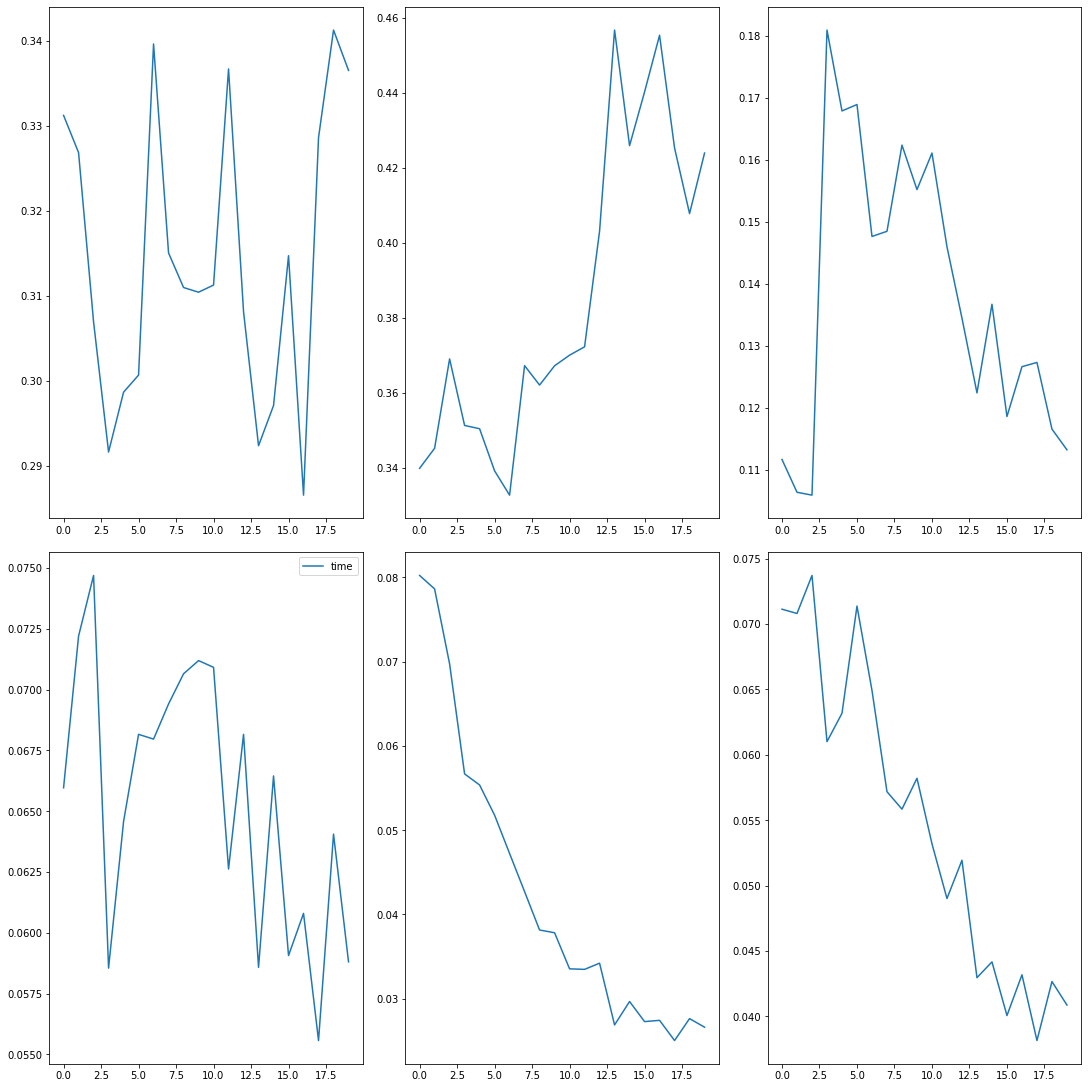

In [31]:
domx=summary[:,0]

ax = plt.figure(constrained_layout=True, figsize=(15,15)).subplot_mosaic(
    [['dom_x', 'dom_y', 'dom_z'],
    ['time', 'charge', 'SRT']])

ax['dom_x'].plot(summary[:,0],label='dom_x')
ax['dom_y'].plot(summary[:,1], label='dom_y')
ax['dom_z'].plot(summary[:,2], label='dom_z')
ax['time'].plot(summary[:,3], label='time')
ax['charge'].plot(summary[:,4], label='charge')
ax['SRT'].plot(summary[:,5], label='SRT')
plt.legend()

In [37]:
grad_dict={'energy':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
           'zenith':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
          'azimuth':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
          'sig_zeni':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
          'sig_azi':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1}}

In [46]:
feats=list(grad_dict[keys[0]].keys())